# An Exercise in Discrete Space Q-Learning

## Solve the Frozen Lake Problem

In this lab you will implement a solution for the frozen lake problem. To help you get started we'll review the Taxi problem solution from Lab 2.

## Reference the Taxi Solution

The training function is defined below:

In [65]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle # for exporting and importing datastructure files
from IPython.display import clear_output

# Training function using Q-Learning
'''
Arguments:
    q_table - The Q-Table to use for training
    num_episdoes - Number of episodes to train
    alpha - learning rate
    gamma - discount factor
    epsilon - exploration rate
'''
def taxi_train(q_table, num_episodes, alpha, gamma, epsilon, verbose=False):
    # Initialize the Taxi Environment
    env = gym.make("Taxi-v2").env
    
    if verbose:
        print("Training for {} episodes".format(num_episodes))

    for i in range(1, num_episodes+1):
        state = env.reset()

        epochs, penalties, reward = 0, 0, 0
        done = False

        while not done:  # Run until episode is solved

            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values
    
            next_state, reward, done, info = env.step(action) 
            
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])
            
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value
    
            if reward == -10:
                penalties += 1
    
            state = next_state
            epochs += 1

        if i % 100 == 0:
            clear_output(wait=True)
            print("\rEpisode: {}".format(i))

    if verbose:
        print("\nTraining finished\n")
        
    env.close()


### Training

Now we can initialize the model variables:
* Number of episodes
* Q-Table
* Hyperparameters

In [66]:
# Initialize the Taxi Environment
env = gym.make("Taxi-v2").env

# Initialize the Q-Table
q_table = np.zeros([env.observation_space.n, env.action_space.n]) # (500, 6) matrix

# Initialize Number of Episodes
train_duration = 10000

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

Then pass these variables to the train function.

In [67]:
taxi_train(q_table, train_duration, alpha, gamma, epsilon)

Episode: 10000


### Evaluation

Now we need a function to evaluate the model. For evaluation we will no longer be chaning the Q-Table values, rather we will only use it to decide what action to make (all 'exploitation' no 'exploration'). Below is the code we used from Lab 2. I've also added two functions for plotting histograms of the results.

In [68]:
# Evaluation function
'''
Arguments:
    q_table - A trained Q-Table
    num_episodes - Number of episodes to run the simulation
Returns:
    all_rewards - A list of the total rewards received per episode, one value for each episode
    all_penalties - A list of the total penalties received per episode, one value for each episode
'''
def taxi_evaluate(q_table, num_episodes, verbose=False):
    # Initialize the Taxi Environment
    env = gym.make("Taxi-v2").env
    
    all_rewards = []
    all_penalties = []

    if verbose:
        print("Evaluating on {} episodes".format(num_episodes))
    for i in range(num_episodes):
        state = env.reset()
        epochs, penalties, reward = 0, 0, 0
        totalreward = 0
        done = False
        
        while not done:
            action = np.argmax(q_table[state])
            state, reward, done, info = env.step(action)
    
            totalreward += reward
    
            if reward == -10:
                penalties += 1
    
            epochs += 1
            if epochs >= 5000: # Cap an episode at 5k timesteps
                break

        clear_output(wait=True)
        print("\rEpisode: {}".format(i))
   
        all_rewards.append(totalreward)
        all_penalties.append(penalties)

    if verbose:
        print("\nEvaluating finished\n")
        print("Mean rewards: {}".format(np.array(all_rewards).mean()))
        print("Mean penalties: {}".format(np.array(all_penalties).mean()))
        
    env.close()
    return all_rewards, all_penalties


def plot_timesteps_histogram(rewards_list):
    fig = plt.figure()
    plt.hist(rewards_list)
    fig.suptitle('Histogram of Timesteps for Taxi Q-Learning', fontsize=20)
    plt.xlabel('Rewards Received', fontsize=18)
    plt.ylabel('Frequency', fontsize=16)
    plt.show()

def plot_penalties_histogram(penalties_list):
    fig = plt.figure()
    plt.hist(penalties_list)
    fig.suptitle('Histogram of Penalties for Taxi Q-Learning', fontsize=20)
    plt.xlabel('Penalties Received', fontsize=18)
    plt.ylabel('Frequency', fontsize=16)
    plt.show()

Episode: 999

Evaluating finished

Mean rewards: -281.844
Mean penalties: 0.0


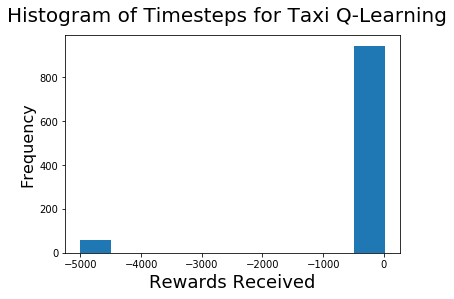

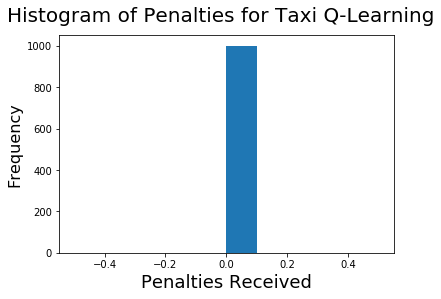

In [70]:
rewards, penalties = taxi_evaluate(q_table, 1000, True)
plot_timesteps_histogram(rewards)
plot_penalties_histogram(penalties)

In [71]:
# Export the learned Q-Table for external use
pickle.dump(q_table, open("taxi_q_table.p", "wb"))

### Render an Episode

It would be nice to see how the agent behaves during an episode so we'll define a run function that saves each frame and plays it back. Similar to the evaluate function, it doesn't update the Q-Table anymore, just exploits what it has learned.

In [72]:
from IPython.display import clear_output
from time import sleep

# Run function
'''
Arguments:
    q_table - A trained Q-Table
'''
def taxi_run(q_table, verbose=False):
    # Initialize the Taxi Environment
    env = gym.make("Taxi-v2").env
    
    frames = []

    state = env.reset()
    epochs, penalties, reward = 0, 0, 0

    done = False

    while not done:
        clear_output(wait=True)
        env.render()
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
            
    # Finished: Print frames
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print("Timestep: {}".format(i+1))
        print("State: {}".format(frame['state']))
        print("Action: {}".format(frame['action']))
        print("Reward: {}".format(frame['reward']))
        sleep(.1)

In [76]:
taxi_run(q_table)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 11
State: 479
Action: 5
Reward: 20


## Frozen Lake

### Training

In [47]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle # for exporting and importing datastructure files
from IPython.display import clear_output

# Training function using Q-Learning
'''
Arguments:
    q_table - The Q-Table to use for training
    num_episdoes - Number of episodes to train
    alpha - learning rate
    gamma - discount factor
    epsilon - exploration rate
'''
def frozenlake_train(q_table, num_episodes, alpha, gamma, epsilon, verbose=False):
    # Initialize the Taxi Environment
    env = gym.make("FrozenLake-v0").env
    
    if verbose:
        print("Training for {} episodes".format(num_episodes))

    for i in range(1, num_episodes+1):
        state = env.reset()

        epochs, penalties, reward = 0, 0, 0
        done = False

        while not done:  # Run until episode is solved

            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values
    
            next_state, reward, done, info = env.step(action) 
        
            if done and reward < 1:    # if fell in hole (finished without a reward of 1)
                reward = -10          # Give big negative reward so Q-Values learn from mistake
                penalties += 1
                
            elif done and reward >= 1:    # if found goal (finished with a reward of 1)
                reward = 1000          # Give big positive reward
                
            else:                     # if did not win or fail yet
                reward = -1         # Give small negative reward to encourage finishing fast
            
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])
            
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value
    
            state = next_state
            epochs += 1
            if epochs >= 2000: # Cap an episode at 2k timesteps
                break
            
        if i % 100 == 0:
            clear_output(wait=True)
            print("\rEpisode: {}".format(i))
            print("\rReward: {}".format(reward))

    if verbose:
        print("\nTraining finished\n")
        
    env.close()

In [48]:
# Initialize the Taxi Environment
env = gym.make("FrozenLake-v0").env

# Initialize the Q-Table
q_table = np.zeros([env.observation_space.n, env.action_space.n]) # (16, 4) matrix

# Initialize Number of Episodes
train_duration = 100000

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

In [49]:
print(q_table.shape)

(16, 4)


In [50]:
frozenlake_train(q_table, train_duration, alpha, gamma, epsilon)

Episode: 100000
Reward: -10


### Evaluation

In [60]:
# Evaluation function
'''
Arguments:
    q_table - A trained Q-Table
    num_episodes - Number of episodes to run the simulation
Returns:
    all_rewards - A list of the number of timesteps it took to solve one episode, one value for each episode
    all_penalties - A list of the total penalties received per episode, one value for each episode
'''
def frozenlake_evaluate(q_table, num_episodes, verbose=False):
    # Initialize the Taxi Environment
    env = gym.make("FrozenLake-v0").env
    
    all_rewards = []
    all_penalties = []

    if verbose:
        print("Evaluating on {} episodes".format(num_episodes))
    for i in range(num_episodes):
        state = env.reset()
        epochs, penalties, reward = 0, 0, 0
        totalreward = 0
        done = False
        
        while not done:
            action = np.argmax(q_table[state])
            state, reward, done, info = env.step(action)

            if done and reward < 1:    # if fell in hole (finished without a reward of 1)
                reward = -10          # Give big negative reward so Q-Values learn from mistake
                penalties += 1
                
            elif done and reward >= 1:    # if found goal (finished with a reward of 1)
                reward = 1000          # Give big positive reward
                
            else:                     # if did not win or fail yet
                reward = -1         # Give small negative reward to encourage finishing fast
            
            
            totalreward += reward
    
            epochs += 1
            if epochs >= 2000: # Cap an episode at 2k timesteps
                break

        clear_output(wait=True)
        print("\rEpisode: {}".format(i))
   
        all_rewards.append(totalreward)
        all_penalties.append(penalties)

    if verbose:
        print("\nEvaluating finished\n")
        print("Mean reward: {}".format(np.array(all_rewards).mean()))
        print("Mean penalties: {}".format(np.array(all_penalties).mean()))
        
    env.close()
    return all_rewards, all_penalties

In [61]:
def plot_timesteps_histogram(rewards_list):
    fig = plt.figure()
    plt.hist(rewards_list)
    fig.suptitle('Histogram of Rewards for FrozenLake Q-Learning', fontsize=20)
    plt.xlabel('Rewards Received', fontsize=18)
    plt.ylabel('Frequency', fontsize=16)
    plt.show()

In [62]:
def plot_penalties_histogram(penalties_list):
    fig = plt.figure()
    plt.hist(penalties_list)
    fig.suptitle('Histogram of Penalties for FrozenLake Q-Learning', fontsize=20)
    plt.xlabel('Penalties Receives', fontsize=18)
    plt.ylabel('Frequency', fontsize=16)
    plt.show()

Episode: 999

Evaluating finished

Mean reward: 202.503
Mean penalties: 0.771


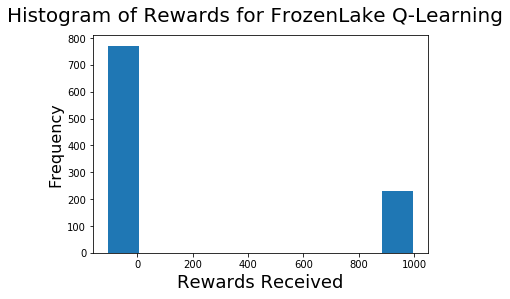

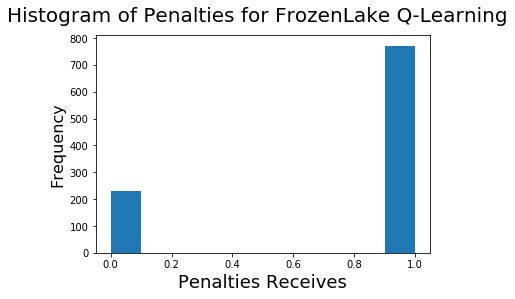

In [63]:
times, penalties = frozenlake_evaluate(q_table, 1000, True)
plot_timesteps_histogram(times)
plot_penalties_histogram(penalties)

### Render an Episode

In [40]:
from IPython.display import clear_output
from time import sleep

# Run function
'''
Arguments:
    q_table - A trained Q-Table
'''
def frozenlake_run(q_table, verbose=False):
    # Initialize the Taxi Environment
    env = gym.make("FrozenLake-v0").env
    
    frames = []

    state = env.reset()
    epochs, penalties, reward = 0, 0, 0

    done = False

    while not done:
        clear_output(wait=True)
        env.render()
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
            
    # Finished: Print frames
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print("Timestep: {}".format(i+1))
        print("State: {}".format(frame['state']))
        print("Action: {}".format(frame['action']))
        print("Reward: {}".format(frame['reward']))
        sleep(.1)

In [64]:
frozenlake_run(q_table)

  (Right)
SFFF
FHFH
FFFH
HFFG

Timestep: 23
State: 5
Action: 2
Reward: 0.0
